In [169]:
from rtgemlib import RTGEM
from rtgemlib import sample_from_tgem, LogLikelihood, scoreBic, mle_lambdas, LocaleLogLikelihood, get_count_duration_df, get_node_LogLikelihood, set_pcv_lambda_t, backward_neighbors_gen,\
compute_logLikelihood, set_nodes_timeseries, set_nodes_parents_counts, duration, get_parents_count_vector, forward_neighbors_gen, initModelFromData

from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [170]:
def empty_nodes(nodes):
    return dict(zip(nodes, [{'timescales': {}, 'lambdas': {(): 1}}] * len(nodes)))

In [171]:
model = {'B': 
            {
            'timescales': {'A' : [[1,2], [5, 6]]},\
            'lambdas': {
                       (0,0): 10, \
                       (0,1): 1.6, \
                       (1,0): 3, \
                       (1,1) : 1
                      }
            },
            'A': {
                'timescales': {'B': [[0,1], [10,15]]},\
                'lambdas': {
                       (0,0): 1, \
                       (0,1): 4, \
                       (1,0): 5, \
                       (1,1) : 9
                      }
            }
        }



In [172]:
rtgem_model = RTGEM(model)

In [173]:
t_max = 10000

## Sampling

In [174]:
sampled_data = sample_from_tgem(rtgem_model, t_min=0, t_max=t_max)

HBox(children=(IntProgress(value=0, description='Sampled Nodes: ', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Sampling A, B:', style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='exporting data to DF', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [238]:
sampled_data

,time,event
51766,0.415894,B
51767,0.938064,B
51768,1.139752,B
51769,1.155926,B
51770,1.346294,B
51771,1.519066,B
51772,1.557985,B
51773,1.757667,B
51774,1.802795,B
51775,1.999618,B


In [175]:
set_pcv_lambda_t(model=rtgem_model, data=sampled_data, t_max=t_max)

In [176]:
count_duration_df = get_count_duration_df(model=rtgem_model, data=sampled_data, t_max=t_max)

## Likelihood

In [177]:
compute_logLikelihood(count_duration_df)

66116.10348264658

In [178]:
LogLikelihood(model=rtgem_model, observed_data=sampled_data, t_max=t_max)

66116.10348264658

## Parameters learning (lambdas)

In [179]:
mle_lambdas(rtgem_model, count_duration_df)

,event,pcv,lambda_t,duration,count
0,B,"(0, 0)",11.320692,1.501675,17
1,B,"(0, 1)",1.114463,36.789005,41
2,B,"(1, 0)",1.838731,40.789005,75
3,B,"(1, 1)",1.056656,9920.920316,10483
4,A,"(0, 0)",0.719203,16.685140,12
5,A,"(0, 1)",3.968393,3374.917949,13393
6,A,"(1, 0)",5.085521,37.360969,190
7,A,"(1, 1)",9.008321,6571.035942,59194


## Structure learning

### Modèle de référence

In [180]:
rtgem_model = RTGEM(empty_nodes(['A', 'B']), default_end_timescale=1)

In [181]:
rtgem_model.add_edge_operator(('A', 'A'))
rtgem_model.add_edge_operator(('A', 'B'))
rtgem_model.add_edge_operator(('B', 'A'))

In [182]:
rtgem_model.split_operator(edge=('A', 'A'), timescale=[0,1])

In [183]:
rtgem_model.extend_operator(edge=('A', 'B'))

In [184]:
sampled_data = sample_from_tgem(rtgem_model, t_min=0, t_max=10000)

HBox(children=(IntProgress(value=0, description='Sampled Nodes: ', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Sampling A, B:', style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='exporting data to DF', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [185]:
t_max = 100
data = sampled_data[sampled_data['time'] < t_max]

In [186]:
initModelFromData(model=rtgem_model, observed_data=data, t_max=t_max)

In [187]:
count_duration_df = get_count_duration_df(model=rtgem_model, data=data, t_max=t_max)

In [188]:
compute_logLikelihood(count_duration_df) - rtgem_model.size() * np.log(t_max)

279.6152126641211

In [189]:
score_bic_reference = scoreBic(rtgem_model, data, t_max)

In [190]:
score_bic_reference

279.6152126641211

### Forward Search

In [191]:
import itertools
import random
import copy

In [192]:
def empty_nodes(nodes):
    return dict(zip(nodes, [{'timescales': {}, 'lambdas': {(): 1}}] * len(nodes)))

In [193]:
model = RTGEM(empty_nodes(['A', 'B']),  default_end_timescale=1)

#### Initialisation 

In [194]:
initModelFromData(model, data, t_max)

In [195]:
count_duration_df = get_count_duration_df(model=model, data=data, t_max=t_max)

In [196]:
lambdas_count_duration_df = mle_lambdas(model=model, count_and_duration=count_duration_df)

In [197]:
model.dpd_graph.nodes.data('lambdas')

NodeDataView({'A': {(): 5.15}, 'B': {(): 0.24}}, data='lambdas')

In [198]:
LogL = compute_logLikelihood(lambdas_count_duration_df)
log_td = np.log(t_max)

size_log_td = model.size() * log_td

score = LogL - size_log_td
nodes = list(model.dpd_graph.nodes)
possible_edges = list(itertools.product(nodes, repeat = 2))

random.shuffle(possible_edges)

In [199]:
scoreBic(model=model, observed_data=data, t_max=t_max)

261.62217515061735

In [200]:
it = 0
forward_logs = []
local_maximum = False

bic_scores_forward = []

while not local_maximum:
    #     max_ngbr_score = -np.inf
    local_maximum = True
    max_score_ngbr = -np.inf
    max_op = None
    max_args = None
    max_changed_node_cnt_drt_df = None
    max_size_log_td_ngbr = None
    max_LogL_ngbr = None
    print('iteration number: {}: scoreBIC = {}'.format(it, score))
    for ngbr_info in forward_neighbors_gen(model, data, t_max, lambdas_count_duration_df,LogL, size_log_td, log_td,\
                                           possible_edges):

        op, args, LogL_ngbr, size_log_td_ngbr, changed_node_cnt_drt_df = ngbr_info
        score_ngbr = LogL_ngbr - size_log_td_ngbr

        if score_ngbr > max_score_ngbr:
            max_score_ngbr = score_ngbr
            max_op = op
            max_args = args
            max_changed_node_cnt_drt_df = changed_node_cnt_drt_df
            max_size_log_td_ngbr = size_log_td_ngbr
            max_LogL_ngbr = LogL_ngbr
    print('max ngbr {}, args={}, max_scoreBIC = {}'.format(max_op, max_args, max_score_ngbr))
 
    if max_score_ngbr > score:
        max_op(*max_args)
        LogL = max_LogL_ngbr
        size_log_td = max_size_log_td_ngbr
        changed_node = max_changed_node_cnt_drt_df.iloc[0]['event']
        lambdas_count_duration_df = lambdas_count_duration_df[lambdas_count_duration_df['event'] != changed_node]
        lambdas_count_duration_df = pd.concat([lambdas_count_duration_df, max_changed_node_cnt_drt_df])

        local_maximum = False
        score = max_score_ngbr
        op_name = 'étendreIntervalle'

        # removes added edge from possible edges
        if max_op == model.add_edge_operator:
            possible_edges.remove(max_args[0])
        # pd.Dataframe(columns=['it', 'T_A', 'T_B', 'edges', 'max_ngbr', 'scoreBic'])
            op_name = 'ajouterArc'
        if max_op == model.split_operator:
            op_name = 'diviserIntervalle'

        forward_logs.append([it, copy.deepcopy(model.get_node_parents_timescales('A')),\
                             copy.deepcopy(model.get_node_parents_timescales('B')),\
                             list(model.dpd_graph.edges()),\
                             op_name,\
                             max_args,\
                             score])
    
    bic_scores_forward.append(score)
    
    it += 1

iteration number: 0: scoreBIC = 261.62217515061735
max ngbr <bound method RTGEM.add_edge_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('B', 'B')], max_scoreBIC = 324.82299590707123
iteration number: 1: scoreBIC = 324.82299590707123
max ngbr <bound method RTGEM.add_edge_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('A', 'A')], max_scoreBIC = 332.68295803682736
iteration number: 2: scoreBIC = 332.68295803682736
max ngbr <bound method RTGEM.split_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('A', 'A'), [0, 1]], max_scoreBIC = 351.86993413431645
iteration number: 3: scoreBIC = 351.86993413431645
max ngbr <bound method RTGEM.split_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('A', 'A'), [0, 0.5]], max_scoreBIC = 459.01114140158245
iteration number: 4: scoreBIC = 459.01114140158245
max ngbr <bound method RTGEM.split_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args

In [201]:
initModelFromData(model=model, observed_data=data, t_max=t_max)

In [203]:
forwardLogs = open("forward.logs", "a")
forwardLogs.write(str(list(forward_logs)))
forwardLogs.close()

In [204]:
count_duration_df = get_count_duration_df(model=model, data=data, t_max=t_max)

In [205]:
mle_lambdas(model, count_duration_df)

,event,pcv,lambda_t,duration,count
0,A,"(0, 0, 0, 0, 0, 0, 0)",0.000000,2.391357,0
1,A,"(0, 0, 0, 0, 0, 0, 1)",0.000000,4.578248,0
2,A,"(0, 0, 0, 0, 0, 1, 0)",0.000000,0.797795,0
3,A,"(0, 0, 0, 0, 0, 1, 1)",0.000000,19.406791,0
4,A,"(0, 0, 0, 0, 1, 0, 0)",0.000000,0.318100,0
5,A,"(0, 0, 0, 0, 1, 0, 1)",0.000000,6.092734,0
6,A,"(0, 0, 0, 0, 1, 1, 0)",0.000000,1.085642,0
7,A,"(0, 0, 0, 0, 1, 1, 1)",0.000000,17.942635,0
8,A,"(0, 0, 0, 1, 0, 0, 0)",0.000000,0.119889,0
9,A,"(0, 0, 0, 1, 0, 0, 1)",0.000000,2.447419,0


In [206]:
scoreBic(model, data, t_max)

1077.298663730266

In [207]:
# keep forward result in memory
forward_model = copy.deepcopy(model)

## BackwardSearch(Forward)

In [208]:
initModelFromData(model=model, observed_data=data, t_max=t_max)
count_duration_df = get_count_duration_df(model=model, data=data, t_max=t_max)

count_duration_df = mle_lambdas(model, count_duration_df)
LogL = compute_logLikelihood(lambdas_count_duration_df)
log_td = np.log(t_max)

size_log_td = model.size() * log_td

score = LogL - size_log_td

In [209]:
score

1077.298663730266

In [210]:
it = 0
backward_logs = []
local_maximum = False

bic_scores_backward = []

while not local_maximum:
    #     max_ngbr_score = -np.inf
    local_maximum = True
    max_score_ngbr = -np.inf
    max_op = None
    max_args = None
    max_changed_node_cnt_drt_df = None
    max_size_log_td_ngbr = None
    max_LogL_ngbr = None
    print('iteration number: {}: scoreBIC = {}'.format(it, score))
    for ngbr_info in backward_neighbors_gen(model, data, t_max, lambdas_count_duration_df,
                                            LogL, size_log_td, log_td,):

        op, args, LogL_ngbr, size_log_td_ngbr, changed_node_cnt_drt_df = ngbr_info
        score_ngbr = LogL_ngbr - size_log_td_ngbr

#         if score_ngbr > max_score_ngbr:
        max_score_ngbr = score_ngbr
        max_op = op
        max_args = args
        max_changed_node_cnt_drt_df = changed_node_cnt_drt_df
        max_size_log_td_ngbr = size_log_td_ngbr
        max_LogL_ngbr = LogL_ngbr

        if max_score_ngbr > score:
            print('max ngbr {}, args={}, max_scoreBIC = {}'.format(max_op, max_args, max_score_ngbr))

            max_op(*max_args)
            LogL = max_LogL_ngbr
            size_log_td = max_size_log_td_ngbr
            changed_node = max_changed_node_cnt_drt_df.iloc[0]['event']
            lambdas_count_duration_df = lambdas_count_duration_df[lambdas_count_duration_df['event'] != changed_node]
            lambdas_count_duration_df = pd.concat([lambdas_count_duration_df, max_changed_node_cnt_drt_df])

            local_maximum = False
            score = max_score_ngbr
            op_name = 'supprimerArc'

            if max_op == model.inverse_extend_operator:
                op_name = 'reduireIntervalle'
            # pd.Dataframe(columns=['it', 'T_A', 'T_B', 'edges', 'max_ngbr', 'scoreBic'])
            if max_op == model.inverse_split_operator:
                op_name = 'FusionnerIntervalle'

            backward_logs.append([it, copy.deepcopy(model.get_node_parents_timescales('A')),\
                                 copy.deepcopy(model.get_node_parents_timescales('B')),\
                                 list(model.dpd_graph.edges()),\
                                 op_name,\
                                 max_args,\
                                 score])
            break
    
    
    bic_scores_backward.append(score)
    
    it += 1

iteration number: 0: scoreBIC = 1077.298663730266
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('A', 'A')], max_scoreBIC = 1363.9769925844355
iteration number: 1: scoreBIC = 1363.9769925844355
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('A', 'A')], max_scoreBIC = 1505.2410524247598
iteration number: 2: scoreBIC = 1505.2410524247598
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('A', 'A')], max_scoreBIC = 1577.2509154628226
iteration number: 3: scoreBIC = 1577.2509154628226
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001A2BBCE7CF8>>, args=[('A', 'A')], max_scoreBIC = 1612.796451048257
iteration number: 4: scoreBIC = 1612.796451048257
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001

In [211]:
backwardLogs = open("backward.logs", "a")
backwardLogs.write(str(list(backward_logs)))
backwardLogs.close()

In [212]:
model.dpd_graph.edges

OutEdgeView([('A', 'A'), ('B', 'B')])

In [213]:
nb_it_forward = len(bic_scores_forward)
nb_it_backward = len(bic_scores_backward)

In [232]:
# abscissa
x = [i for i in range(nb_it_forward + nb_it_backward)]

# ordinate
y_for = bic_scores_forward
y_back = bic_scores_backward

In [233]:
# ordinate
y_ref = [score_bic_reference for i in range(nb_it_forward + nb_it_backward)]

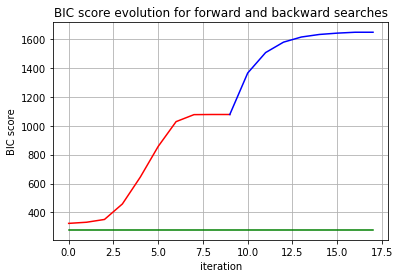

In [237]:


# plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(x)[:nb_it_forward], y_for, 'r', np.array(x)[(nb_it_forward-1):], y_back, "b", x, y_ref, "g")


ax.set(xlabel='iteration', ylabel='BIC score',
       title='BIC score evolution for forward and backward searches')
ax.grid()

fig.savefig("images/BICscore.png")

In [228]:
initModelFromData(model=model, observed_data=data, t_max=t_max)

In [229]:
count_duration_df = get_count_duration_df(model=model, data=data, t_max=t_max)

In [230]:
count_duration_df

,event,pcv,lambda_t,duration,count
0,A,"(0,)",5.943004,92.269479,0
1,A,"(1,)",4.815429,7.730521,515
2,B,"(0,)",5.682484,95.592784,0
3,B,"(1,)",0.710821,4.407216,24


In [231]:
mle_lambdas(model, count_duration_df)

,event,pcv,lambda_t,duration,count
0,A,"(0,)",0.000000,92.269479,0
1,A,"(1,)",66.619056,7.730521,515
2,B,"(0,)",0.000000,95.592784,0
3,B,"(1,)",5.445615,4.407216,24
